In [1]:
import sys
import yaml
with open('..//secrets.yml', 'r') as file:
    secrets = yaml.safe_load(file)
sys.path.append(secrets['elo_proj_path'])

In [2]:
from player_club_classes import team_elo, Player, Club, Match
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import plotly
import pickle
import datetime

from support_files.team_colors import team_color_dict
team_colors = pd.DataFrame(team_color_dict).T
team_colors.columns = ['Primary', 'Secondary']
team_colors = team_colors.rename_axis('Team').reset_index()

from plotly.validators.scatter.marker import SymbolValidator
raw_symbols = SymbolValidator().values

simple_symbols = [i for i in raw_symbols if str(i).isalpha()]

with open('../../Rugby_ELO/processed_data/playerbase.pickle', 'rb') as handle:
    playerbase = pickle.load(handle)
with open('../../Rugby_ELO/processed_data/matchlist.pickle', 'rb') as handle:
    matchlist = pickle.load(handle)
with open('../../Rugby_ELO/processed_data/teamlist.pickle', 'rb') as handle:
    teamlist = pickle.load(handle)

In [3]:
match_list = []
for _, match in matchlist.items():
    match_list.append({
        key: val for key, val in vars(match).items()
        #if key not in ['home_team', 'away_team']
        })

match_df = pd.DataFrame(match_list)
match_df = match_df.drop(['home_team', 'away_team', 'commentary_df'], axis = 1)
match_df = match_df[~match_df.point_diff.isna()]

In [4]:
player_elo_list = []
for player_name, player in playerbase.items():
    player_elo = pd.DataFrame(player.elo_list, columns = [
        'Number', 'Full_Name', 'Team', 'Player', 'Position', 'Tries',
        'Try Assists', 'Conversion Goals', 'Penalty Goals',
        'Drop Goals Converted', 'Points', 'Passes', 'Runs', 'Meters Run',
        'Clean Breaks', 'Defenders Beaten', 'Offload', 'Turnovers Conceded',
        'Tackles', 'Missed Tackles', 'Lineouts Won', 'Penalties Conceded',
        'Yellow Cards', 'Red Cards', 'espn_id_num', 'Competition', 'Date',
        'Home Team', 'Home Score', 'Away Team', 'Away Score', 'Minutes',
        'Position_Number', 'gameid', 'Unicode_ID', 'comp_level', 'start_elo', 'end_elo'
       ])
    player_elo['Full Name'] = player_name[0]
    player_elo['Unicode_ID'] = player_name[1]
    player_elo_list.append(player_elo)

player_elo = pd.concat(player_elo_list).reset_index(drop=True)
player_elo = pd.merge(player_elo, team_colors, on = 'Team', how = 'left')
player_elo['elo_change'] = player_elo.end_elo - player_elo.start_elo
player_elo.Date = pd.to_datetime(player_elo.Date)

player_elo['week_num'] = player_elo['Date'].dt.isocalendar().week
player_elo['month'] = player_elo['Date'].dt.month
player_elo['year'] = player_elo['Date'].dt.year

player_elo.loc[player_elo.Position == 'BR', 'Position'] = 'N8'

starters = player_elo[player_elo.Position != 'R']
starters = starters.dropna(subset=['Position'])

In [5]:
#monthly_percentiles
from plot_functions import *

starters = player_elo[player_elo.Position != 'R']
starters = starters.dropna(subset=['Position'])
last_date_of_months = player_elo.groupby(pd.Grouper(key="Date", freq='M')).Date.max()
percentile_list = []

for date in last_date_of_months:
    current_players = starters[starters.Date < date]
    current_players = current_players[current_players.Date >= date - datetime.timedelta(days=365)]
    current_players = current_players[current_players.groupby(['Full Name'])['Date'].transform(max) == current_players['Date']].copy()
    percentile_df = current_players.groupby('Position')['end_elo'].quantile([0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]).reset_index()
    percentile_df.columns = ['Position', 'Percentile', 'elo']
    percentile_df = percentile_df.pivot(index = 'Position', columns = 'Percentile')
    percentile_df.columns = ["Percentile_" + str(int(x*100)) for x in percentile_df.columns.droplevel()]
    percentile_df = percentile_df.reset_index()
    percentile_df['year'] = date.year
    percentile_df['month'] = date.month

    mean_df = current_players.groupby('Position')['end_elo'].mean().reset_index()
    mean_df.columns = ['Position', 'elo_mean']
    percentile_df = percentile_df.merge(mean_df)

    percentile_list.append(percentile_df)
    
percentile_df = pd.concat(percentile_list)
percentile_df['dates'] = pd.to_datetime(percentile_df['year'].astype(int).astype(str)  + percentile_df['month'].astype(int).astype(str).str.pad(2, fillchar = '0'), format='%Y%m')

percentile_df.tail()

,Position,Percentile_5,Percentile_10,Percentile_25,Percentile_50,Percentile_75,Percentile_90,Percentile_95,year,month,elo_mean,dates
5,L,78.911019,84.114676,90.715883,95.313329,101.024487,109.455485,114.195343,2022.0,10.0,95.920585,2022-10-01
6,N8,80.348001,84.836899,91.256251,96.026196,101.809162,111.865818,118.848689,2022.0,10.0,97.087528,2022-10-01
7,P,83.095820,86.785443,92.108918,95.940362,100.443949,106.198401,111.109186,2022.0,10.0,96.232425,2022-10-01
8,SH,82.836898,86.939916,91.922029,95.125399,101.694133,108.049556,114.373345,2022.0,10.0,96.665575,2022-10-01
9,W,82.439446,86.445105,91.584692,95.712116,101.528724,110.939299,116.126521,2022.0,10.0,97.245773,2022-10-01


In [6]:
plt.rcParams['figure.figsize'] = [15, 7]

Text(0.5, 1.0, 'Median')

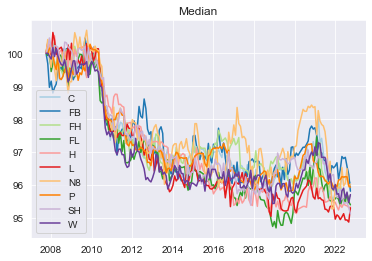

In [7]:
positions = percentile_df.Position.unique()
colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#ffff99']
cmap = zip(positions, colors[0:len(positions)])  # zip values to colors

for position, color in cmap:
    plt_set = percentile_df[percentile_df.Position == position]
    plt.plot(plt_set.dates, plt_set.Percentile_50, c=color)

plt.legend(positions)
plt.title('Median')
## Definitely have some rating deflation. Not great

Text(0.5, 1.0, 'Mean')

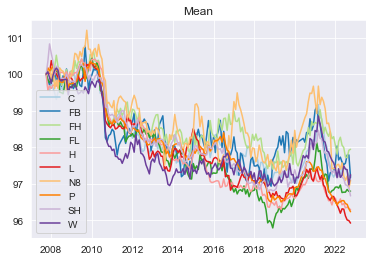

In [8]:
positions = percentile_df.Position.unique()
colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#ffff99']
cmap = zip(positions, colors[0:len(positions)])  # zip values to colors

for position, color in cmap:
    plt_set = percentile_df[percentile_df.Position == position]
    plt.plot(plt_set.dates, plt_set.elo_mean, c=color)

plt.legend(positions)
plt.title('Mean')

In [9]:
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

def player_history_plot(player_df):
    fig, ax = plt.subplots()
    playername = player_df.Full_Name.iloc[0]
    player_df['play_position'] = np.where(player_df.Position == 'R', np.nan, player_df.Position)
    player_df['play_position'] = player_df['play_position'].fillna(method = 'bfill')
    player_df['play_position'] = player_df['play_position'].fillna(method = 'ffill')
    player_df = player_df.merge(percentile_df, how='left', left_on = ['play_position','year','month'], right_on = ['Position','year','month'])
    
    ax.plot(player_df.Date, player_df.elo_mean, color = 'white')
    ax.plot(player_df.Date, player_df.Percentile_50, color = 'grey')
    ax.fill_between(player_df.Date, player_df.Percentile_5, player_df.Percentile_95, alpha=0.2, color = 'grey')
    ax.fill_between(player_df.Date, player_df.Percentile_10, player_df.Percentile_90, alpha=0.2, color = 'grey')
    ax.fill_between(player_df.Date, player_df.Percentile_25, player_df.Percentile_75, alpha=0.2, color = 'grey')

    for _, sub1 in player_df.groupby('Team'):
        for _, team_subset in sub1.groupby(sub1.Competition):
            ax.scatter(team_subset.Date, team_subset.end_elo,c = team_subset.Primary, edgecolors=team_subset.Secondary)
    plt.title(f'{playername}: elo History')
    ax.set_ylabel('elo score')

    # Creating legend with color box
    Interval50 = mpatches.Patch(color='grey', label='50% elo Interval', alpha = 0.6)
    Interval80 = mpatches.Patch(color='grey', label='80% elo Interval', alpha = 0.4)
    Interval95 = mpatches.Patch(color='grey', label='95% elo Interval', alpha = 0.2)
    point = mlines.Line2D([0], [0], marker='o', color='w', label='Post Match elo',
                      markerfacecolor='black', markersize=10, ls = '')
    plt.legend(handles=[Interval50, Interval80, Interval95, point])

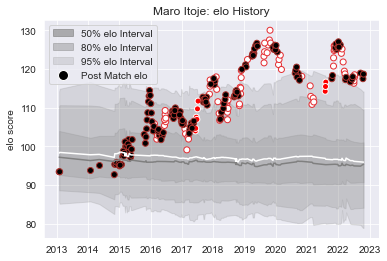

In [10]:
player_df = player_elo[player_elo.Full_Name == 'Maro Itoje'].copy()
player_df['opponent'] = np.where(player_df.Team == player_df['Home Team'], player_df['Away Team'], player_df['Home Team'])
player_df['win'] = np.where(
    (player_df['Home Score'] > player_df['Away Score']) & (player_df.Team == player_df['Home Team']) | 
    (player_df['Home Score'] < player_df['Away Score']) & (player_df.Team == player_df['Away Team']), 1, 0)
player_df.loc[player_df['Home Score'] == player_df['Away Score'], 'win'] = 0.5
player_history_plot(player_df)

In [203]:
name = player_df.Full_Name.iloc[0]
current_elo = player_df.end_elo.iloc[-1]
current_percentile = player_df.merge(make_current_percentile(starters, player_df.Date.iloc[-1])).percentile[0]
positions = player_df[player_df.Position != 'R'].Position.value_counts(normalize=True).loc[lambda x : x > 0.1].keys().tolist()[0:2]
print(name, positions, np.round(current_elo, 2), current_percentile)

Maro Itoje ['L', 'FL'] 113.18 88.0


In [196]:
player_df.Team.value_counts()

Saracens                   137
England                     54
British and Irish Lions      9
Name: Team, dtype: int64

In [197]:
player_df.groupby('Team').win.mean().sort_values(ascending=False)

Team
Saracens                   0.802920
England                    0.685185
British and Irish Lions    0.500000
Name: win, dtype: float64

In [198]:
player_df.groupby('Team')['Meters Run'].sum().sort_values(ascending=False).head()

Team
Saracens                   2136.0
England                     700.0
British and Irish Lions     112.0
Name: Meters Run, dtype: float64

In [199]:
player_df.loc[player_df['end_elo'].idxmax()]

Number                                                  4.0
Full_Name                                        Maro Itoje
Team                                                England
Player                                              M Itoje
Position                                                  L
Tries                                                   0.0
Try Assists                                             0.0
Conversion Goals                                        0.0
Penalty Goals                                           0.0
Drop Goals Converted                                    0.0
Points                                                  0.0
Passes                                                  0.0
Runs                                                    8.0
Meters Run                                             20.0
Clean Breaks                                            0.0
Defenders Beaten                                        0.0
Offload                                 

In [200]:
player_df.columns

Index(['Number', 'Full_Name', 'Team', 'Player', 'Position', 'Tries',
       'Try Assists', 'Conversion Goals', 'Penalty Goals',
       'Drop Goals Converted', 'Points', 'Passes', 'Runs', 'Meters Run',
       'Clean Breaks', 'Defenders Beaten', 'Offload', 'Turnovers Conceded',
       'Tackles', 'Missed Tackles', 'Lineouts Won', 'Penalties Conceded',
       'Yellow Cards', 'Red Cards', 'espn_id_num', 'Competition', 'Date',
       'Home Team', 'Home Score', 'Away Team', 'Away Score', 'Minutes',
       'Position_Number', 'gameid', 'Unicode_ID', 'comp_level', 'start_elo',
       'end_elo', 'Full Name', 'Primary', 'Secondary', 'elo_change',
       'week_num', 'month', 'year', 'opponent', 'win', 'play_position'],
      dtype='object')

In [201]:
same_comp = match_df[
    (match_df.competition == 'Gallagher Premiership 2019') & 
    ((match_df.home_team_name == 'Saracens')|(match_df.away_team_name == 'Saracens'))].copy()

same_comp['win'] = np.where(
    (same_comp.home_score > same_comp.away_score) & (same_comp.home_team_name == 'Saracens') | 
    (same_comp.home_score < same_comp.away_score) & (same_comp.away_team_name == 'Saracens'), 1, 0)
same_comp.loc[same_comp.home_score == same_comp.away_score, 'win'] = 0.5

same_comp['team_elo_adv'] = np.where(
    same_comp.home_team_name == 'Saracens', same_comp.elo_diff, same_comp.elo_diff * -1
)
same_comp['team_elo'] = np.where(
    same_comp.home_team_name == 'Saracens', same_comp.home_elo, same_comp.away_elo
)
same_comp['opponent_elo'] = np.where(
    same_comp.home_team_name == 'Saracens', same_comp.away_elo, same_comp.home_elo
)

missing_player = same_comp[~same_comp.name.isin(player_df.gameid)]
with_player = same_comp[same_comp.name.isin(player_df.gameid)]

print(with_player.team_elo.mean(), missing_player.team_elo.mean())
print(with_player.opponent_elo.mean(), missing_player.opponent_elo.mean())
print(with_player.win.mean(), missing_player.win.mean())

1711.8971532389742 1600.1628704076445
1571.3567921609986 1571.5254483778056
0.9166666666666666 0.5833333333333334


In [80]:
player_df.columns

Index(['Number', 'Full_Name', 'Team', 'Player', 'Position', 'Tries',
       'Try Assists', 'Conversion Goals', 'Penalty Goals',
       'Drop Goals Converted', 'Points', 'Passes', 'Runs', 'Meters Run',
       'Clean Breaks', 'Defenders Beaten', 'Offload', 'Turnovers Conceded',
       'Tackles', 'Missed Tackles', 'Lineouts Won', 'Penalties Conceded',
       'Yellow Cards', 'Red Cards', 'espn_id_num', 'Competition', 'Date',
       'Home Team', 'Home Score', 'Away Team', 'Away Score', 'Minutes',
       'Position_Number', 'gameid', 'Unicode_ID', 'comp_level', 'start_elo',
       'end_elo', 'Full Name', 'Primary', 'Secondary', 'elo_change',
       'week_num', 'month', 'year', 'opponent', 'play_position'],
      dtype='object')

In [6]:
def percentile(group):
    sz = group.size-1
    ranks = group.rank(method='max')
    return np.floor(100.0*(ranks-1)/sz)

starters = player_elo[player_elo.Position != 'R']
starters = starters.dropna(subset=['Position'])
current_players = starters[starters.groupby(['Full Name'])['Date'].transform(max) == starters['Date']]
current_players['percentile'] = np.floor(current_players.groupby('Position')['end_elo'].apply(percentile))
current_players = current_players[['Full_Name', 'Unicode_ID', 'percentile']]
current_players

C:\Users\Graeham\AppData\Local\Temp\ipykernel_20984\1572876672.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  current_players['percentile'] = np.floor(current_players.groupby('Position')['end_elo'].apply(percentile))


,Full_Name,Unicode_ID,percentile
264,Nick Abendanon,55485151,97.0
401,Mike Tindall,49485155,81.0
550,Anthony Allen,55545151,82.0
568,James Bailey,53485349,38.0
800,Ryan Lamb,55515350,48.0
...,...,...,...
504376,Ignacio Peculo,1101119510111511211095105100327310311097991051...,5.0
504377,Ignacio Dotti,1101119510111511211095105100327310311097991051...,7.0
504380,Jordi Jorba,1101119510111511211095105100327411111410010532...,14.0
504381,Alejandro Alonso Munoz,1101119510111511211095105100326510810110697110...,14.0


In [7]:
match_list = []
for _, match in matchlist.items():
    match_list.append({key:val for key, val in vars(match).items()})

In [16]:
import datetime

recent_games = [x for x in match_list if datetime.datetime.now() > x['date'] > datetime.datetime.now() - datetime.timedelta(days=7)]
[print(f'{x["away_team_name"]} at {x["home_team_name"]}') for x in recent_games]


France at Japan
Wales at South Africa
Scotland at Argentina
Argentina at Portugal
Ireland at New Zealand
England at Australia
Romania at Uruguay
Spain at Canada
Italy at Georgia


[None, None, None, None, None, None, None, None, None]

In [45]:
recent_game['home_elo']

1675.7560946117012

In [46]:
recent_game = recent_games[4]
home_team = pd.DataFrame(recent_game['home_team'][:, [0,1,31,-2, -1]], columns = ['Number', 'Full_Name', 'Minutes', 'Unicode_ID', 'elo'])
home_team = home_team.merge(current_players, on=['Full_Name', 'Unicode_ID'])
home_team = home_team.drop(['Unicode_ID'], axis = 1)
away_team = pd.DataFrame(recent_game['away_team'][:, [0,1,31,-2, -1]], columns = ['Number', 'Full_Name', 'Minutes', 'Unicode_ID', 'elo'])
away_team = away_team.merge(current_players, on=['Full_Name', 'Unicode_ID'])
away_team = away_team.drop(['Unicode_ID'], axis = 1)

home_team.columns = ['Number', 'Home Player', 'Home Minutes', 'Home elo', 'Home Percentile']
away_team.columns = ['Number', 'Away Player', 'Away Minutes', 'Away elo', 'Away Percentile']

all_players = pd.merge(home_team, away_team)
all_players = all_players.sort_values('Number')
all_players = all_players[['Away Minutes', 'Away Player', 'Away elo','Away Percentile', 'Number', 'Home Percentile', 'Home elo', 'Home Player', 'Home Minutes']]
all_players

,Away Minutes,Away Player,Away elo,Away Percentile,Number,Home Percentile,Home elo,Home Player,Home Minutes
7,65.0,Andrew Porter,105.791011,89.0,1.0,23.0,93.745562,George Bower,64.0
2,64.0,Dan Sheehan,81.261693,13.0,2.0,66.0,101.597315,Codie Taylor,57.0
4,65.0,Tadhg Furlong,103.024992,84.0,3.0,94.0,113.700592,Ofa Tu'ungafasi,81.0
3,81.0,Tadhg Beirne,108.25333,90.0,4.0,98.0,126.019121,Brodie Retallick,69.0
6,69.0,James Ryan,100.072725,73.0,5.0,95.0,117.793807,Scott Barrett,74.0
8,76.0,Peter O'Mahony,105.402545,89.0,6.0,89.0,108.457896,Dalton Papalii,59.0
15,81.0,Josh van der Flier,120.38603,98.0,7.0,99.0,125.56057,Sam Cane,81.0
5,69.0,Caelan Doris,96.760505,55.0,8.0,87.0,111.091316,Ardie Savea,33.0
1,69.0,Jamison Gibson-Park,112.194505,95.0,9.0,94.0,113.885827,Aaron Smith,62.0
14,74.0,Johnny Sexton,128.806876,99.0,10.0,98.0,124.983873,Beauden Barrett,57.0


In [61]:
all_players.apply(pd.to_numeric, errors='ignore').round({'Home elo':2, 'Away elo':2})

,Away Minutes,Away Player,Away elo,Away Percentile,Number,Home Percentile,Home elo,Home Player,Home Minutes
7,65.0,Andrew Porter,105.79,89.0,1.0,23.0,93.75,George Bower,64.0
2,64.0,Dan Sheehan,81.26,13.0,2.0,66.0,101.60,Codie Taylor,57.0
4,65.0,Tadhg Furlong,103.02,84.0,3.0,94.0,113.70,Ofa Tu'ungafasi,81.0
3,81.0,Tadhg Beirne,108.25,90.0,4.0,98.0,126.02,Brodie Retallick,69.0
6,69.0,James Ryan,100.07,73.0,5.0,95.0,117.79,Scott Barrett,74.0
8,76.0,Peter O'Mahony,105.40,89.0,6.0,89.0,108.46,Dalton Papalii,59.0
15,81.0,Josh van der Flier,120.39,98.0,7.0,99.0,125.56,Sam Cane,81.0
5,69.0,Caelan Doris,96.76,55.0,8.0,87.0,111.09,Ardie Savea,33.0
1,69.0,Jamison Gibson-Park,112.19,95.0,9.0,94.0,113.89,Aaron Smith,62.0
14,74.0,Johnny Sexton,128.81,99.0,10.0,98.0,124.98,Beauden Barrett,57.0


In [6]:
future_games = [x for x in match_list if 'point_diff' not in x.keys()]

In [36]:
future_game = future_games[0]

home_team = pd.DataFrame(future_game['home_team'][:, [0,1,-2, -1]], columns = ['Number', 'Full_Name', 'Unicode_ID', 'elo'])
home_team = home_team.merge(current_players, on=['Full_Name', 'Unicode_ID'])
home_team = home_team.drop(['Unicode_ID'], axis = 1)
home_team = home_team.sort_values('Number')

away_team = pd.DataFrame(future_game['away_team'][:, [0,1,-2, -1]], columns = ['Number', 'Full_Name', 'Unicode_ID', 'elo'])
away_team = away_team.merge(current_players, on=['Full_Name', 'Unicode_ID'])
away_team = away_team.drop(['Unicode_ID'], axis = 1)
away_team = away_team.sort_values('Number')

home_team.columns = ['Number', 'Home Name', 'Home elo', 'Home Percentile']
away_team.columns = ['Number', 'Away Name', 'Away elo', 'Away Percentile']

all_players = pd.merge(home_team, away_team)
all_players = all_players.sort_values('Number')
all_players

NameError: name 'future_games' is not defined

In [40]:
## Draft attribution chart
def lineup_contribition(player_df, column):
    mult = np.where(player_df.Number <= 15, (7/8), 0.234)
    return player_df[column] * mult

all_players['home contributions'] = lineup_contribition(all_players, 'Home elo')
all_players['away contributions'] = lineup_contribition(all_players, 'Away elo')
all_players['home minute_elos'] = all_players['Home elo'] * all_players['Home Minutes'] / max(all_players['Home Minutes'])
all_players['away minute_elos'] = all_players['Away elo'] * all_players['Away Minutes'] / max(all_players['Home Minutes'])

all_players[['Number', 'home contributions', 'away contributions', 'home minute_elos', 'away minute_elos']]

,Number,home contributions,away contributions,home minute_elos,away minute_elos
7,1.0,82.027367,92.567135,74.070568,84.894021
2,2.0,88.897651,71.103982,71.494407,64.20677
4,3.0,99.488018,90.146868,113.700592,82.674376
3,4.0,110.266731,94.721663,107.349621,108.25333
6,5.0,103.069581,87.563634,107.614096,85.247136
8,6.0,94.900659,92.227227,79.000196,98.896215
15,7.0,109.865499,105.337776,125.56057,120.38603
5,8.0,97.204902,84.665442,45.259425,82.425616
1,9.0,99.650098,98.170192,87.171867,95.573097
14,10.0,109.360889,112.706017,87.951615,117.675418


In [41]:
long_players = all_players[['Number', 'home contributions', 'away contributions', 'home minute_elos', 'away minute_elos']].melt(id_vars = 'Number')
fig = px.bar(long_players, x="variable", y="value", color = 'Number')
fig.show()

In [42]:
import plotly.graph_objects as go

pos_plotlist = []
for _, row in all_players.iterrows():
    pos_plot = go.Bar(
        name=row.Number,
        x = ['Home Projected', 'Home Actual', 'Away Projected', 'Away Actual'],
        y = [row['home contributions'], row['home minute_elos'], row['away contributions'], row['away minute_elos']],
        customdata = [row['Home Player'], row['Home Player'], row['Away Player'], row['Away Player']],
        hovertemplate = 
            "<b>%{customdata}</b>: " + 
            "%{y}"
    )
    pos_plotlist.append(pos_plot)

fig = go.Figure(data=pos_plotlist)
# Change the bar mode
fig.update_layout(barmode='stack')
fig.show()

In [43]:
fig = go.Figure(data=pos_plotlist)
# Change the bar mode
fig.update_layout(barmode='stack')
fig.show()

In [41]:
row = all_players.iloc[0]
row

Number                               1.0
Home Name                  Keita Inagaki
Home elo                       95.693948
Home Percentile                     34.0
Away Name             Jean-Baptiste Gros
Away elo                      114.835326
Away Percentile                     96.0
home contributions             83.732204
away contributions             100.48091
Name: 0, dtype: object

In [9]:
month = match_df[(match_df.year == 2022) & (match_df.month == 7)]
closest_games = month.sort_values('lineup_spread',  key=abs).head()

sorted_pred_accuracy = month.assign(tmp=month["point_diff"] - month["lineup_spread"]).sort_values(by="tmp", key=abs)#.drop(columns="tmp")
best_preds = sorted_pred_accuracy.head()
worst_preds = sorted_pred_accuracy.tail()

biggest_upsets = month[(month.lineup_spread * month.point_diff) < 0].assign(tmp=month["point_diff"] - month["lineup_spread"]).sort_values(by="tmp", key=abs, ascending=False).drop(columns="tmp").head()
biggest_covers = month[((month.lineup_spread * month.point_diff) > 0)].assign(tmp=month["point_diff"] - month["lineup_spread"]).sort_values(by="tmp", key=abs, ascending=False)#.drop(columns="tmp").head()

NameError: name 'match_df' is not defined

In [7]:
# CHANGE
player_month = player_elo[(player_elo.year == 2022) & (player_elo.month == 5)]
oneplayer = player_month[(player_month.Unicode_ID == '5155544848') & (player_month['Full Name'] == 'Caleb Delany')].sort_values('Date')
oneplayer.iloc[-1].end_elo - oneplayer.iloc[0].start_elo

-2.554117441069806

In [11]:
def elo_change(df):
    return df.iloc[-1].end_elo, df.iloc[0].start_elo, df.iloc[-1].end_elo - df.iloc[0].start_elo

elo_changes = player_month.sort_values('Date').groupby(['Unicode_ID', 'Full Name', 'Team']).apply(elo_change).reset_index()
elo_changes[['end_elo', 'start_elo', 'elo_change']] = pd.DataFrame(elo_changes[0].tolist(), index=elo_changes.index)
elo_changes.sort_values('elo_change')

,Unicode_ID,Full Name,Team,0,end_elo,start_elo,elo_change
576,5051515156,James Blackwell,Hurricanes,"(100.88391371265058, 106.42990302317858, -5.54...",100.883914,106.429903,-5.545989
826,5055485550,Salesi Rayasi,Hurricanes,"(110.70188334521939, 115.67822631062886, -4.97...",110.701883,115.678226,-4.976343
1070,5149525654,Quinn Tupaea,Chiefs,"(113.26707089934938, 118.08496318931884, -4.81...",113.267071,118.084963,-4.817892
267,5048485452,Ardie Savea,Hurricanes,"(118.33886733853684, 122.95562106235826, -4.61...",118.338867,122.955621,-4.616754
589,5051515748,Josh Ioane,Chiefs,"(98.22976447566921, 102.77928260508381, -4.549...",98.229764,102.779283,-4.549518
...,...,...,...,...,...,...,...
406,5049535052,Mattia Bellini,Benetton Treviso,"(96.79422627952788, 92.30762615721996, 4.48660...",96.794226,92.307626,4.486600
745,5053505254,Rhyno Smith,Benetton Treviso,"(99.09602275738854, 94.60942263508062, 4.48660...",99.096023,94.609423,4.486600
244,4957555455,Juan Ignacio Brex,Benetton Treviso,"(98.82188475913395, 94.33528463682603, 4.48660...",98.821885,94.335285,4.486600
408,5049535155,Federico Ruzza,Benetton Treviso,"(102.4315904715746, 97.94499034926667, 4.48660...",102.431590,97.944990,4.486600
